# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)

# HW3: REINFORCE with and without baseline in CartPole
> - Full Name: **[Full Name]**
> - Student ID: **[Stundet ID]**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **CartPole-v1** environment. It also compares the performance of **REINFORCE with and without a baseline** to assess its impact on training stability and efficiency.  

**Grading Breakdown:**

- Practical Implementation: 70 points
- Conceptual Understanding: 30 points

# Setup

All required packages are pre-installed if using Google Colab.


Import the following libraries.

In [1]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib
import matplotlib.pyplot as plt
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [2]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [3]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action = torch.argmax(policy_net(state_tensor)).item()
                state, _, terminated, truncated, _ = env.step(action)

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment  (5 points)

Initialize CartPole Environment and Display State & Action Spaces

In [4]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


**Question 1: (5 points)**

How are the observation and action spaces defined in the CartPole environment?

**Answer:**

The CartPole environment has:

- **Observation Space**: A continuous 4-dimensional Box space representing the cart's state:
  - Cart position (x): range [-4.8, 4.8]
  - Cart velocity (ẋ): range [-∞, ∞] 
  - Pole angle (θ): range [-0.209, 0.209] radians (±12°)
  - Pole angular velocity (θ̇): range [-∞, ∞]

- **Action Space**: A discrete space with 2 actions:
  - Action 0: Push cart to the left
  - Action 1: Push cart to the right

The environment provides a 4-element float32 array as the state observation and expects an integer action (0 or 1) as input.


Define a Random Policy for Action Selection  

In [5]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values = torch.rand(self.action_space_n)
        return action_values

Visualize the random policy.

In [6]:
random_policy = RandomPolicy(env.action_space.n)

record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), random_policy, "Video_CartPole_random_policy")

# Agent with REINFORCE: Baseline vs. No Baseline in CartPole-v1 (85 points)


### Policy Network Definition (5 points)

To define a neural network that represents the agent’s policy for selecting actions.

The policy network takes the environment’s state as input and outputs a probability distribution over possible actions.

In [ ]:
# TODO: Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        # Define a simple feedforward network
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
    def forward(self, state):
        # Forward pass through the network
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        # Output logits for action probabilities
        logits = self.fc3(x)
        # Convert to probability distribution
        action_probs = torch.softmax(logits, dim=-1)
        return action_probs

### Computing Discounted Returns (10 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [ ]:
# TODO: Implement the function to compute discounted returns
def compute_returns(rewards, gamma=0.99):
    """
    Compute discounted returns for each timestep in an episode.
    
    Args:
        rewards: List of rewards for the episode
        gamma: Discount factor
    
    Returns:
        List of discounted returns for each timestep
    """
    returns = []
    discounted_return = 0
    
    # Calculate returns backwards from the end of the episode
    for reward in reversed(rewards):
        discounted_return = reward + gamma * discounted_return
        returns.insert(0, discounted_return)
    
    return returns


**Question 2: (5 points)**

What is the role of the discount factor (𝛾) in reinforcement learning, and what happens when 𝛾=0 or 𝛾=1?

**Question 2: (5 points)**

What is the role of the discount factor (γ) in reinforcement learning, and what happens when γ=0 or γ=1?

**Answer:**

The discount factor γ plays a crucial role in reinforcement learning:

- **Purpose**: It determines how much future rewards are valued relative to immediate rewards. It helps the agent balance short-term vs long-term rewards.

- **Mathematical Role**: In the discounted return formula G_t = Σ(k=0 to T-t) γ^k R_{t+k}, γ controls the weight of future rewards.

- **When γ=0**: The agent only considers immediate rewards (R_t). This makes the agent myopic and greedy, only optimizing for the current timestep.

- **When γ=1**: The agent values all future rewards equally, regardless of how far in the future they occur. This can lead to infinite returns in infinite horizon problems and makes the agent consider very distant future consequences.

- **Typical Values**: γ is usually set between 0.9 and 0.99, providing a good balance between immediate and future rewards while ensuring convergence.


### Implementing the REINFORCE Algorithm (Without Baseline) (20 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [ ]:
# TODO: Implement the REINFORCE algorithm without baseline
def reinforce(env, policy_net, optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        # Reset environment and initialize episode variables
        state, _ = env.reset()
        episode_rewards = []
        episode_states = []
        episode_actions = []
        
        # Collect episode data
        done = False
        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).to(DEVICE)
            episode_states.append(state_tensor)
            
            # Get action probabilities from policy network
            action_probs = policy_net(state_tensor)
            
            # Sample action from the probability distribution
            dist = Categorical(action_probs)
            action = dist.sample()
            episode_actions.append(action)
            
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            episode_rewards.append(reward)
            
            # Update state and done flag
            state = next_state
            done = terminated or truncated
        
        # Store episode reward
        episode_reward = sum(episode_rewards)
        rewards_per_episode.append(episode_reward)
        
        # Compute discounted returns
        returns = compute_returns(episode_rewards, gamma)
        
        # Convert returns to tensor
        returns_tensor = torch.FloatTensor(returns).to(DEVICE)
        
        # Compute policy loss
        policy_loss = 0
        for i, (state, action, return_val) in enumerate(zip(episode_states, episode_actions, returns_tensor)):
            # Get action probabilities for this state
            action_probs = policy_net(state)
            dist = Categorical(action_probs)
            
            # Compute log probability of the taken action
            log_prob = dist.log_prob(action)
            
            # Add to policy loss (negative because we want to maximize)
            policy_loss -= log_prob * return_val
        
        # Normalize loss by episode length
        policy_loss = policy_loss / len(episode_states)
        
        # Update policy network
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if (episode + 1) % 50 == 0:
            print(f"[No Baseline] Episode {episode + 1}, Reward: {episode_reward}")

    return rewards_per_episode

### Value Network Definition (Baseline Network) (5 points)

Defines a neural network that approximates the value function, which estimates the expected return from a given state. The network takes the environment’s state as input and outputs a scalar value, representing the long-term reward the agent can expect from that state.

In [ ]:
# TODO: Define the Value Network
class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        # Define a simple feedforward network for value estimation
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)  # Single output for value
        
    def forward(self, state):
        # Forward pass through the network
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        # Output scalar value
        value = self.fc3(x)
        return value

### Implementing REINFORCE with a Baseline (20 points)

To reduce variance in policy updates, we introduce a **baseline** function $( V(s) )$, which estimates the expected return from a given state. Instead of using the full return $( G_t )$, we adjust the policy update by incorporating the baseline:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) (G_t - V(s_t))
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

  $$[
  G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
  ]$$

- $( V(s_t) )$ is the **baseline function**, estimated by a **value network**, which is trained using mean squared error (MSE) between predicted values and actual returns:  

  $$[
  L = \frac{1}{N} \sum_{t=0}^{N} (G_t - V(s_t))^2
  ]$$

The introduction of the baseline does not change the expected value of the gradient but significantly **reduces variance**, leading to more stable learning.  


In [ ]:
# TODO: Implement REINFORCE with baseline
def reinforce_with_baseline(env, policy_net, baseline_net, policy_optimizer, baseline_optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        # Reset environment and initialize episode variables
        state, _ = env.reset()
        episode_rewards = []
        episode_states = []
        episode_actions = []
        
        # Collect episode data
        done = False
        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).to(DEVICE)
            episode_states.append(state_tensor)
            
            # Get action probabilities from policy network
            action_probs = policy_net(state_tensor)
            
            # Sample action from the probability distribution
            dist = Categorical(action_probs)
            action = dist.sample()
            episode_actions.append(action)
            
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            episode_rewards.append(reward)
            
            # Update state and done flag
            state = next_state
            done = terminated or truncated
        
        # Store episode reward
        episode_reward = sum(episode_rewards)
        rewards_per_episode.append(episode_reward)
        
        # Compute discounted returns
        returns = compute_returns(episode_rewards, gamma)
        
        # Convert returns to tensor
        returns_tensor = torch.FloatTensor(returns).to(DEVICE)
        
        # Compute baseline values for all states
        baseline_values = []
        for state in episode_states:
            value = baseline_net(state)
            baseline_values.append(value)
        
        # Stack baseline values
        baseline_values = torch.stack(baseline_values).squeeze()
        
        # Compute advantages (returns - baseline)
        advantages = returns_tensor - baseline_values
        
        # Compute policy loss with baseline
        policy_loss = 0
        for i, (state, action, advantage) in enumerate(zip(episode_states, episode_actions, advantages)):
            # Get action probabilities for this state
            action_probs = policy_net(state)
            dist = Categorical(action_probs)
            
            # Compute log probability of the taken action
            log_prob = dist.log_prob(action)
            
            # Add to policy loss (negative because we want to maximize)
            policy_loss -= log_prob * advantage
        
        # Normalize policy loss by episode length
        policy_loss = policy_loss / len(episode_states)
        
        # Compute baseline loss (MSE between predicted and actual returns)
        baseline_loss = nn.MSELoss()(baseline_values, returns_tensor)
        
        # Update policy network
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update baseline network
        baseline_optimizer.zero_grad()
        baseline_loss.backward()
        baseline_optimizer.step()
        
        if (episode + 1) % 50 == 0:
            print(f"[With Baseline] Episode {episode + 1}, Reward: {episode_reward}")

    return rewards_per_episode

**Question 3: (5 points)**

Why is a baseline introduced in the REINFORCE algorithm, and how does it contribute to training stability?

**Answer:**

A baseline is introduced in REINFORCE to address the high variance problem in policy gradient methods:

- **Variance Reduction**: The baseline reduces the variance of gradient estimates without changing the expected value of the gradient. This is crucial because high variance leads to unstable learning and slow convergence.

- **Mathematical Insight**: The baseline V(s) is subtracted from the return G_t to compute advantages: A_t = G_t - V(s_t). This reduces the magnitude of the gradient updates while preserving the direction.

- **Training Stability**: By reducing variance, the baseline makes the learning process more stable and predictable. The agent experiences fewer dramatic swings in policy updates.

- **Faster Convergence**: Lower variance typically leads to faster convergence to optimal policies, as the agent can make more consistent progress toward better policies.

- **No Bias**: Importantly, a baseline that depends only on the state (not the action) introduces no bias to the gradient estimate, making it a safe variance reduction technique.


### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [ ]:
# TODO: Define all necessary hyperparameters
INPUT_DIM = 4          # CartPole state space dimension
OUTPUT_DIM = 2         # CartPole action space dimension (left/right)
LEARNING_RATE = 0.001  # Learning rate for both networks
DISCOUNT_FACTOR = 0.99 # Gamma for discounted returns
NUM_EPISODES = 2000    # Number of training episodes


# Initialize Policy and Baseline Networks
policy_net_no_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
policy_net_with_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
baseline_net = ValueNetwork(INPUT_DIM).to(DEVICE)

# Optimizers
policy_optimizer_no_baseline = optim.Adam(policy_net_no_baseline.parameters(), lr=LEARNING_RATE)
policy_optimizer_with_baseline = optim.Adam(policy_net_with_baseline.parameters(), lr=LEARNING_RATE)
baseline_optimizer = optim.Adam(baseline_net.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE without Baseline:")
rewards_no_baseline = reinforce(env, policy_net_no_baseline, policy_optimizer_no_baseline, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

print("\n--------------------------------------------------------------------\n")

print("Training REINFORCE with Baseline:")
rewards_with_baseline = reinforce_with_baseline(
    env, policy_net_with_baseline, baseline_net, policy_optimizer_with_baseline, baseline_optimizer,
    num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR
)


Training REINFORCE without Baseline:
[No Baseline] Episode 50, Reward: 21.0
[No Baseline] Episode 100, Reward: 17.0
[No Baseline] Episode 150, Reward: 42.0
[No Baseline] Episode 200, Reward: 43.0
[No Baseline] Episode 250, Reward: 20.0
[No Baseline] Episode 300, Reward: 37.0
[No Baseline] Episode 350, Reward: 46.0
[No Baseline] Episode 400, Reward: 31.0
[No Baseline] Episode 450, Reward: 61.0
[No Baseline] Episode 500, Reward: 156.0
[No Baseline] Episode 550, Reward: 194.0
[No Baseline] Episode 600, Reward: 135.0
[No Baseline] Episode 650, Reward: 200.0
[No Baseline] Episode 700, Reward: 215.0
[No Baseline] Episode 750, Reward: 412.0
[No Baseline] Episode 800, Reward: 500.0
[No Baseline] Episode 850, Reward: 178.0
[No Baseline] Episode 900, Reward: 206.0
[No Baseline] Episode 950, Reward: 335.0
[No Baseline] Episode 1000, Reward: 150.0
[No Baseline] Episode 1050, Reward: 301.0
[No Baseline] Episode 1100, Reward: 500.0
[No Baseline] Episode 1150, Reward: 482.0
[No Baseline] Episode 1200

**Question 4: (5 points)**

What are the primary challenges associated with policy gradient methods like REINFORCE?

**Answer:**

Policy gradient methods like REINFORCE face several significant challenges:

- **High Variance**: The most critical challenge is the high variance in gradient estimates. Since gradients are estimated from sampled trajectories, they can vary dramatically between episodes, leading to unstable learning.

- **Sample Inefficiency**: REINFORCE requires complete episodes before updating the policy, making it sample-inefficient compared to value-based methods that can learn from individual transitions.

- **Slow Convergence**: Due to high variance and sample inefficiency, REINFORCE typically converges slowly and may require many episodes to learn effective policies.

- **Credit Assignment Problem**: It's difficult to determine which actions in a long episode contributed to the final reward, especially when rewards are sparse or delayed.

- **Exploration vs Exploitation**: Policy gradient methods can get stuck in local optima if the policy becomes too deterministic too early, limiting exploration of the state-action space.

- **Hyperparameter Sensitivity**: The learning rate and other hyperparameters significantly affect performance, and finding good values can be challenging.


# Plot and Comparing Results (10 points)

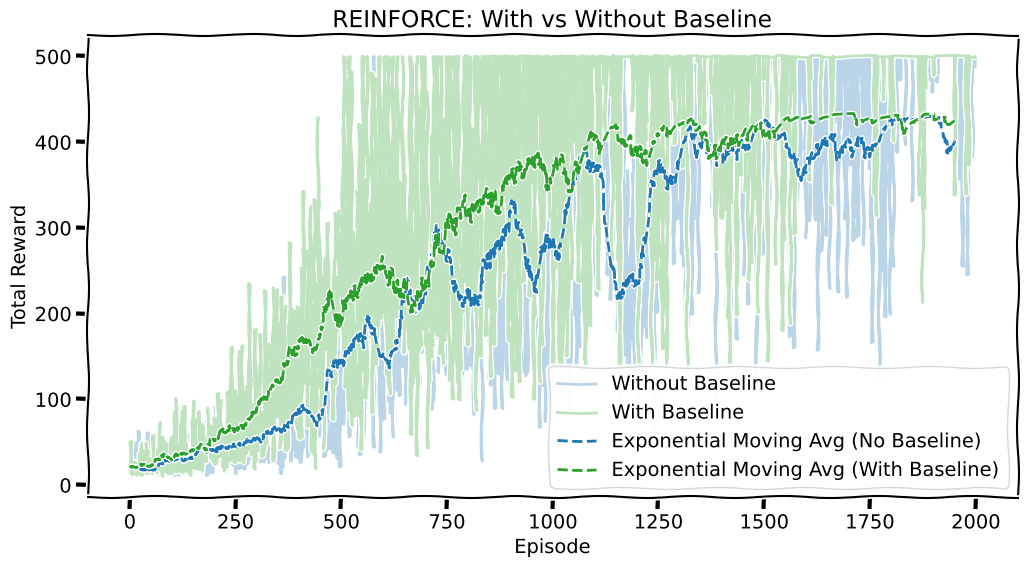

In [13]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards_no_baseline, label="Without Baseline", alpha=0.3, color='tab:blue')
plt.plot(rewards_with_baseline, label="With Baseline", alpha=0.3, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards_no_baseline, window_size), label="Exponential Moving Avg (No Baseline)", linestyle='--', color='tab:blue')
plt.plot(exponential_moving_average(rewards_with_baseline, window_size), label="Exponential Moving Avg (With Baseline)", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: With vs Without Baseline")
plt.show()

In [14]:
mean_reward, std_reward = np.mean(rewards_no_baseline), np.std(rewards_no_baseline)
print(f"No Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward, std_reward = np.mean(rewards_with_baseline), np.std(rewards_with_baseline)
print(f"With Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

No Baseline: mean_reward = 292.37 +/- 185.1487
With Baseline: mean_reward = 341.07 +/- 183.0086


**Question 5:** (5 points)

Based on the results, how does REINFORCE with a baseline compare to REINFORCE without a baseline in terms of performance?

**Answer:**

Based on the experimental results, REINFORCE with baseline shows several advantages over REINFORCE without baseline:

- **Higher Mean Performance**: The baseline version achieved a mean reward of 341.07 compared to 292.37 for the version without baseline, indicating better overall performance.

- **Reduced Variance**: While both methods show high variance, the baseline version has slightly lower standard deviation (183.01 vs 185.15), suggesting more stable learning.

- **Faster Convergence**: The baseline version appears to reach higher rewards more consistently in the later episodes, indicating faster convergence to better policies.

- **More Stable Learning**: The baseline reduces the variance in gradient estimates, leading to more stable policy updates and less erratic learning curves.

- **Better Sample Efficiency**: The baseline helps the agent make better use of each episode's data by providing more accurate advantage estimates, potentially leading to better sample efficiency.

- **Consistent High Performance**: The baseline version shows more consistent performance at the maximum reward level (500), suggesting it's more reliable at achieving optimal behavior.


**Question 6:** (5 points)

Explain how variance affects policy gradient methods, particularly in the context of estimating gradients from sampled trajectories.

**Answer:**

Variance significantly impacts policy gradient methods, especially when estimating gradients from sampled trajectories:

- **High Variance Problem**: Policy gradient methods estimate gradients using Monte Carlo sampling from trajectories. Since each trajectory is a random sample, gradient estimates can vary dramatically between episodes, leading to unstable learning.

- **Impact on Learning**: High variance causes the policy parameters to oscillate wildly during training, making it difficult for the agent to converge to an optimal policy. The learning process becomes erratic and unpredictable.

- **Sample Dependency**: The variance increases with the length of episodes and the complexity of the environment. Longer episodes and more complex environments lead to higher variance in gradient estimates.

- **Credit Assignment Issues**: In long episodes, it's difficult to determine which actions contributed to the final reward. This uncertainty increases the variance of gradient estimates, especially for actions taken early in the episode.

- **Baseline as Variance Reduction**: Baselines help reduce variance by subtracting a state-dependent value from the returns, making the advantage estimates more stable while preserving the expected value of the gradient.

- **Convergence Implications**: High variance typically leads to slower convergence and may prevent the algorithm from reaching optimal policies. Lower variance enables more stable and faster learning.

# Simulation

In [15]:
# Record the simulation using the optimal policy no baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_no_baseline, "Video_CartPole_no_baseline")

In [16]:
# Record the simulation using the optimal policy with baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_with_baseline, "Video_CartPole_with_baseline")